**Notes and Reference**

This is my personal android dev learning notebook.

The majority of the code from a handler video tutorial by Coding in flow. Link to the original tutorial is provided below. Have fun learning :) !

- Coding in Flow (2018) How to Start a Background Thread in Android https://www.youtube.com/watch?v=QfQE1ayCzf8&ab_channel=CodinginFlow

0 중요 개념
- 안드로이드에서 동영상 촬영에 필요한 개념
    - `TextureView`
    - `View.SurfaceView`: SurfaceView는 그리기를 시스템에 맡기는 것이 아니라 스레드를 이용해 강제로 화면에 그림으로써 원하는 시점에 바로 화면에 그릴 수 있다.
        - 애니메이션, 동영상처럼 연산처리가 많이 필요한 뷰에 사용


    SurfaceView로부터 상속받을 경우 디폴트로 구현해야 할 메소드가 있다.

    public void onDraw (Canvas canvas) : 화면을 그린다.
    public void surfaceChanged() : 뷰가 변경될 때 호출된다.
    public void surfaceCreated() : 뷰가 생성될 때 호출된다.
    public void surfaceDestroyed() : 뷰가 종료될 때 호출된다.  


- 실시간으로 변경되는 이미지 출력에 쓰이는 그래픽 가속 기술
    - `Open GL (Open GL ES, Web GL)`
    - `Direct X`
    - 스마트폰에서는 이러한 기술을 사용하도록 wraping된 API 제공
    - `Open GL`을 직접 사용하는 것이 어렵기 때문에 이런 기술을 사용하기 쉽도록 해주는 프래임 워크로 유명한 2가지는 `C#` 기반의 `Unity`와 `C++`기반의 `Unreal`


**참고문헌**
발그레환이 (2017) [Android] SurfaceView 개념 및 예제 https://blog.naver.com/muri1004/221054311714

In [4]:
nt = NoteTaker("RealTime Camera")

- `Activity`
하나의 모델 <---> 하나의 `Activity`
이런 형태로 만들면 여러가지 역할을 수행하는 App을 개발할 때 `Activity`가 많이 필요하여 자원 낭비가 발생할 수 있음.
  - `Activity`는 `Component`이며 생성시점을 알 수 없어 메모리 관리가 어려워진다. 
  - `Resource`는 앱이 실행될 때 전부 메모리에 로드가 됨. 

- `Fragment` 
    - MVC (Mode View Controller) pattern: 프로그램을 역할별로 분할해서 구현하는 구조(Architecture) 관련 패턴
    - 스마트폰에서 서버를 이용할 때: 하나의 `Activity`에더 다른 `Activity`로 전환될 때 네트워크 연결이 끊어지면 아무것도 출력하지 못함.
    - Web의 `Ajax`를 생각해보면 쉬움.


- `MVVM` pattern: V(View), V(View Model) 구조
   - 스마트폰에서 사용하는 구조의 패턴

- `Design Pattern`
OOP에서 `class`를 어떻게 설계할 것인가 하는 문제. `Gof`의 디자인 패턴


- `Thread`
    - `Thread`와 `Handler`
    - 음악 듣기 앱: 음악을 틀어 놓은 상태에서 목록의 다른 음악을 검색할 수 있음.
    


- 동적 권한 취득
    - 스마트폰은 개인 정보를 저장하고, 모든 App은 이 공용 데이터에 접근할 수 있다. 따라서 이런 공용 데이터를 사용하고자 하는 경우 사용자가 적절한 권한을 부여할 수 있어야 함.
    - `정적 권한`: App을 설치할 때나 처음 실행할 때 권한을 한 번만 요청함. 
    - `동적 권한`: App 실행 시마다 권한 요청.


# 0 프로젝트 시작 설정

1. Android Project 생성 – RealtimeImageClassification
2. module 수준의 build.gradle 파일의 dependencies 에 텐서플로 라이트 라이브러리의 의존성 추가   

        implementation 'org.tensorflow:tensorflow-lite:2.4.0'
        implementation 'org.tensorflow:tensorflow-lite-support:0.1.0’


3. Project에 assets 디렉토리를 생성하고 `mobilenet_imagenet_model.tflite` 파일 과 `labels.txt` 파일을 복사
4. 권한 추가

        <uses-feature android:name="android.hardware.camera" android:required="true" />
        <uses-permission android:name="android.permission.CAMERA" />

5. `Classifier.java` 생성


In [ ]:
public class Classifier {

    private static final String MODEL_NAME = "mobilenet_imagenet_model.tflite";
    private static final String LABEL_FILE = "labels.txt";

    Context context;
    Model model;
    int modelInputWidth, modelInputHeight, modelInputChannel;
    TensorImage inputImage;
    TensorBuffer outputBuffer;               # 추론 결과 저장 변수
    private List<String> labels;
    private boolean isInitialized = false;

}

## `private TensorImage loadImage()` 

- 이미지 회전은 전처리할 때 함께 적용할 수 있으므로 `ImageProcessor`가 구현된
`loadimage( )` 함수 안에 `sensorOrientation` 값을 전달
- 회전을 고려하지 않는 기존 로직과의 호환성 을 위해 sensorOrientation 값을 인자로 받지 않는 `classify( )` 함수도 없애지 않고 유지하는 대신 sensorOrientation 값을 전달받지 않은 경우 오버로딩된 `classify( )` 함수에 sensorOrientation 값으로 0을 전달하여 실제로는 회전 되지 않게 함
- `classify ( )` 함수 안에서 회전을 적용하려면 `ImageProcessor`에 `Rot90Op` 연산을 추가
- `Rot90Op` 연산을 적용하면 이미지가 전처리될 때 `numRotation * -90`만큼 회전되는데 값이 `1이면 -90도 회전`,  `2이면 -180도 회전`
- 회전을 추가하면서 이미지의 왜곡을 줄이도록 `ResizeWithCropOrPadOp` 연산도 추가하는
데 이 연산은 딥러닝 모델이 입력받는 이미지의 가로 세로 비율과 카메라가 전달하는 이미
지의 가로 세로 비율이 다를 때 유효
- 딥러닝 모델은 가로와 세로 길이가 같은 정사각형 이미지를 입력받지만 카메라가 전달하는
이미지는 가로와 세로 길이가 다르기 때문에 가로와 세로 중 길이가 짧은 축을 기준으로 길
이가 긴 축을 잘라서 정사각형 이미지를 만듬

In [ ]:
# Classifier.java    
    ...
    
    private TensorImage loadImage(final Bitmap bitmap, int sensorOrientation) {
        if(bitmap.getConfig() != Bitmap.Config.ARGB_8888) {
            inputImage.load(convertBitmapToARGB8888(bitmap));
        } else {
            inputImage.load(bitmap);
        }
        int cropSize = Math.min(bitmap.getWidth(), bitmap.getHeight());
        int numRotation = sensorOrientation / 90;
        ImageProcessor imageProcessor = new ImageProcessor.Builder()
                .add(new ResizeWithCropOrPadOp(cropSize, cropSize))
                .add(new ResizeOp(modelInputWidth, modelInputHeight, NEAREST_NEIGHBOR))
                .add(new Rot90Op(numRotation))
                .add(new NormalizeOp(0.0f, 255.0f))
                .build();
        return imageProcessor.process(inputImage);
    }

    ...

## `TextureView`
동영상 미리보기를 제공하는 `TextureView` 클래스를 상속받는 클래스 작성
- 이전에는 `SurfaceView`만 제공이 되었지만 지금은 `SurfaceView`보다 알파나 회전 처리가 뛰어난 `TextureView`도 제공. 
  - for Deepfake: 동영상 합성할 때는 `SurfaceView`가 성능이 뛰어남


- 코틀린 코드는 안드로이드 스튜디오, Intelli J에서 서로 변환(호환) 가능.
- 구글은 안드로이드에 대한 API 지원을 앞으로는 `Kotlin`으로만 제공. 
- 네이버는 `Backend Spring` 개발에 `Kotlin`을 사용.
- 중견기업들은 서버를 구축할 때 `Kotlin`이나 `node.js`를 많이 사용. 
- 언어의 경계가 무의미해져가고 있다.


## `fragment_camera.xml`
`Fragment` 클래스를 상속받는 `CameraFragment` 클래스 생성 
- 이전에 만든 `TextureView`를 `MainActivity` 클래스에 출력하는 역할

# 1 UI

## `TextView`

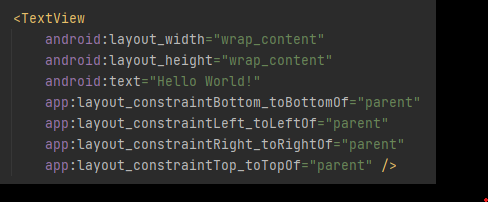

In [6]:
path = "/content/here/MyDrive/Android/RealTime Camera/UI/TextView.png"
nt.show_img(path)

# 2 `Java`

## `Semaphore`
- In computer science, a semaphore is a variable or abstract data type used to control access to a common resource by multiple processes and avoid critical section problems in a concurrent system such as a multitasking operating system. A trivial semaphore is a plain variable that is changed (for example, incremented or decremented, or toggled) depending on programmer-defined conditions ([위키피디아](https://en.wikipedia.org/wiki/Semaphore_(programming))).

## `deprication`

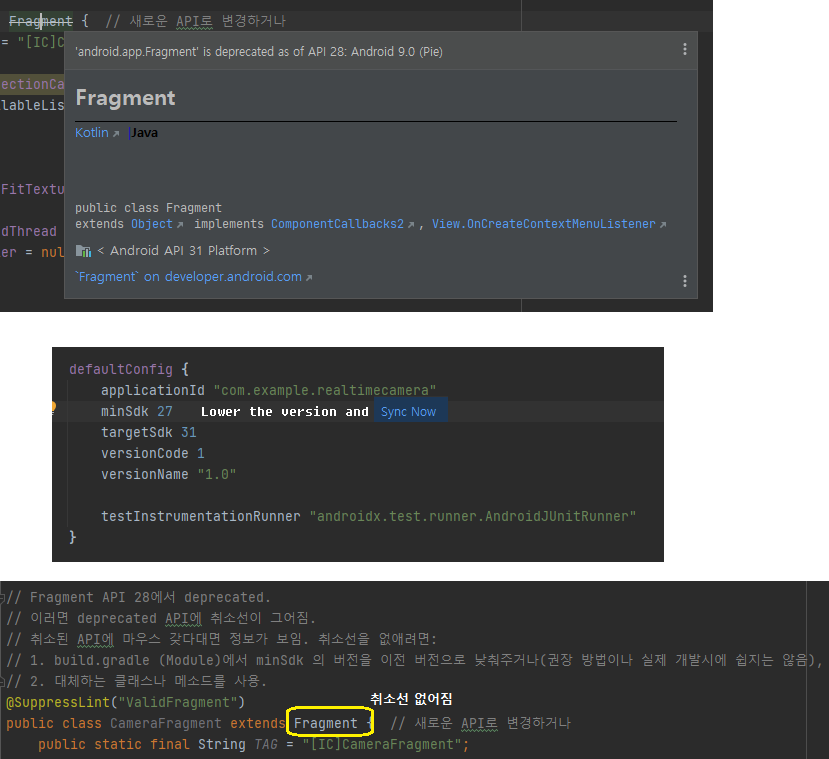

In [7]:
path = "/content/here/MyDrive/Android/RealTime Camera/Java/02 deprication.png"
nt.show_img(path)

# Error Notes